In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import visdom
import numpy as np
import os
import sys
from scipy.io import savemat
import scipy.io     # used to load .mat data
from torch.utils.data import DataLoader, TensorDataset
from utils import *
#from tqdm import tqdm
import cv2
import pytorch_ssim
from image_process import MetaShape
import random
import argparse
import os
import sys
import torch
import json

from utils import Params, evaluate_forward_dataset, evaluate_tandem_accuracy,evaluate_tandem_prediction, evaluate_vae_GSNN_accuracy, evaluate_cGAN_accuracy
from net.ArbitraryShape import GeneratorNet, SimulatorNet, SimulatorNet_new, SimulatorNet_new_linear, SimulatorNet_small, InverseNet, InverseNet_new, cVAE_GSNN, cVAE_hybrid, TandemNet, cGAN
from datasets import get_dataloaders, SiliconSpectrum
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

from sklearn.metrics import r2_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#DEVICE = 'cpu'

In [3]:
# define some functions 


def sharp_image(image, cut_off = 0.5, del_roudn = 0):
    # binarize a generated image, use the cut_off 0.5 for [0,1]
    # image size: 64*64

    image_sharp = image.copy()
    image_sharp[image_sharp<cut_off] = 0
    image_sharp[image_sharp>=cut_off] = 1

    if del_roudn==1:
        image_sharp[0,:]=0
        image_sharp[63,:]=0
        image_sharp[:,0]=0
        image_sharp[:,63]=0

    return image_sharp


def image_area(img):
    # calculate the area of a binarized image by counting all the 1 
    # make sure all the elements of images are [0,1]
    # image size: 64*64

    return np.sum(img)

def compute_edge(images, H=64, W=64):
    # compute the gradient of a images 
    # input: binarized images [0,1]
    # ref: https://www.codingame.com/playgrounds/38470/how-to-detect-circles-in-images
    # return: the length of edge; the coordinates of edges, the image contains edges

    images_fill = np.zeros([H+2, W+2])
    images_fill[1:H+1, 1:W+1] = images
    images_edge = np.zeros([H, W])

    for i in range(1,(H+1),1):
        for j in range(1, (W+1), 1):
            temp_1 = images_fill[i,j]
            temp_2 = images_fill[i,j+1]
            temp_3 = images_fill[i+1,j]
            if (temp_2-temp_1 ==1.0) :
                images_edge[i, j+1] = 1.0
            elif temp_2-temp_1 == -1.0 :
                images_edge[i,j] = 1.0
            if (temp_3-temp_1 == 1.0) :
                images_edge[i+1, j] = 1.0
            elif temp_3-temp_1 == -1.0 :
                images_edge[i,j] = 1.0
            
    edge = []
    for i in range(H):
        for j in range(W):
            if images_edge[i,j] == 1.0:
                edge.append([i,j])
    
    edges_len = np.sum(images_edge)

    return edges_len, edge, images_edge


def irre_cal(edges):
    # calculate the irregularity rate 
    center = np.average(edges, axis=0)
    # print(center)
    dis = []
    for [i,j] in edges:
        dis.append(np.sqrt((i-center[0])**2+(j-center[1])**2))
    # print(np.max(dis), np.min(dis), np.average(dis))
    
    return (np.max(dis)-np.min(dis))/np.average(dis)


def circle_rate(edges_len, image_area):
    # combine together and return 2 irregularity
    # image: [0,1]
    # output: 

    return (edges_len/(2*np.pi))**2/((image_area+1)/np.pi)




In [4]:
# Check the diversity of predicted structures for tandem, VAE and GAN


Num = 3317

shape_file = "./data_predicted/tandem_pred_num_"+str(Num)+"_rep_1000_times_kernel_5_cut_0.3.mat"
temp = scipy.io.loadmat(shape_file)
gap_target_t, gap_pred_t = temp['gap_target'], temp['gap_pred']
shape_raw_t, shape_pred_t, shape_pred_t_raw = temp['shape_target'], temp['shape_pred_sharp'], temp['shape_pred']
spec_target_t = temp['spec_target']
irr_pred_t = temp['irr_pred']

shape_file = "./data_predicted/vae_pred_num_"+str(Num)+"_rep_1000_times_kernel_5_cut_0.3.mat"
temp = scipy.io.loadmat(shape_file)
gap_target_v, gap_pred_v = temp['gap_target'], temp['gap_pred']
shape_raw_v, shape_pred_v, shape_pred_v_raw = temp['shape_target'], temp['shape_pred_sharp'], temp['shape_pred']
spec_target_v = temp['spec_target']
irr_pred_v = temp['irr_pred']

shape_file = "./data_predicted/gan_pred_num_"+str(Num)+"_rep_1000_times_kernel_5_cut_0.3.mat"
temp = scipy.io.loadmat(shape_file)
gap_target_g, gap_pred_g = temp['gap_target'], temp['gap_pred']
shape_raw_g, shape_pred_g, shape_pred_g_raw = temp['shape_target'], temp['shape_pred_sharp'], temp['shape_pred']
spec_target_g = temp['spec_target']
irr_pred_g = temp['irr_pred']

spec_target = spec_target_g
irr_raw = temp['irr_target']


spec_file = "./data_predicted/tandem_pred_num_"+str(Num)+"_rep_1000_times_kernel_5_cut_0.3_spectrum.mat"
spec_pred_t = scipy.io.loadmat(spec_file)['all_spectrum_cut']

spec_file = "./data_predicted/vae_pred_num_"+str(Num)+"_rep_1000_times_kernel_5_cut_0.3_spectrum.mat"
spec_pred_v = scipy.io.loadmat(spec_file)['all_spectrum_cut']

spec_file = "./data_predicted/gan_pred_num_"+str(Num)+"_rep_1000_times_kernel_5_cut_0.3_spectrum.mat"
spec_pred_g = scipy.io.loadmat(spec_file)['all_spectrum_cut']



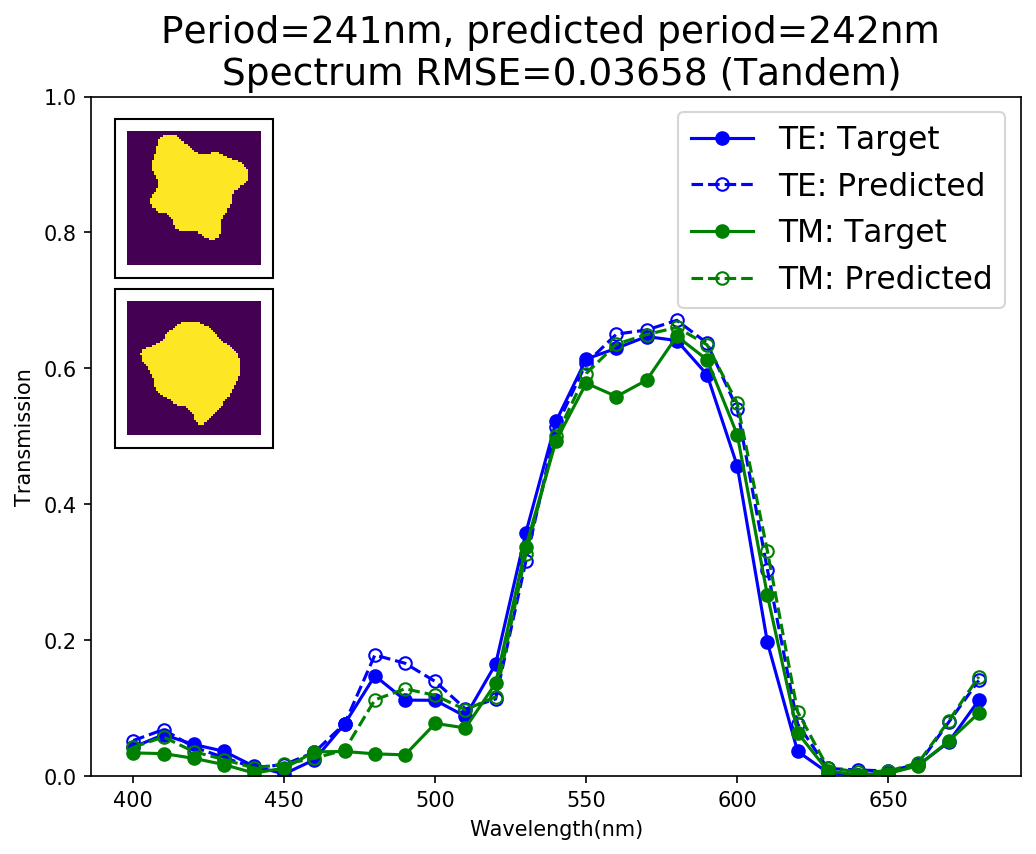

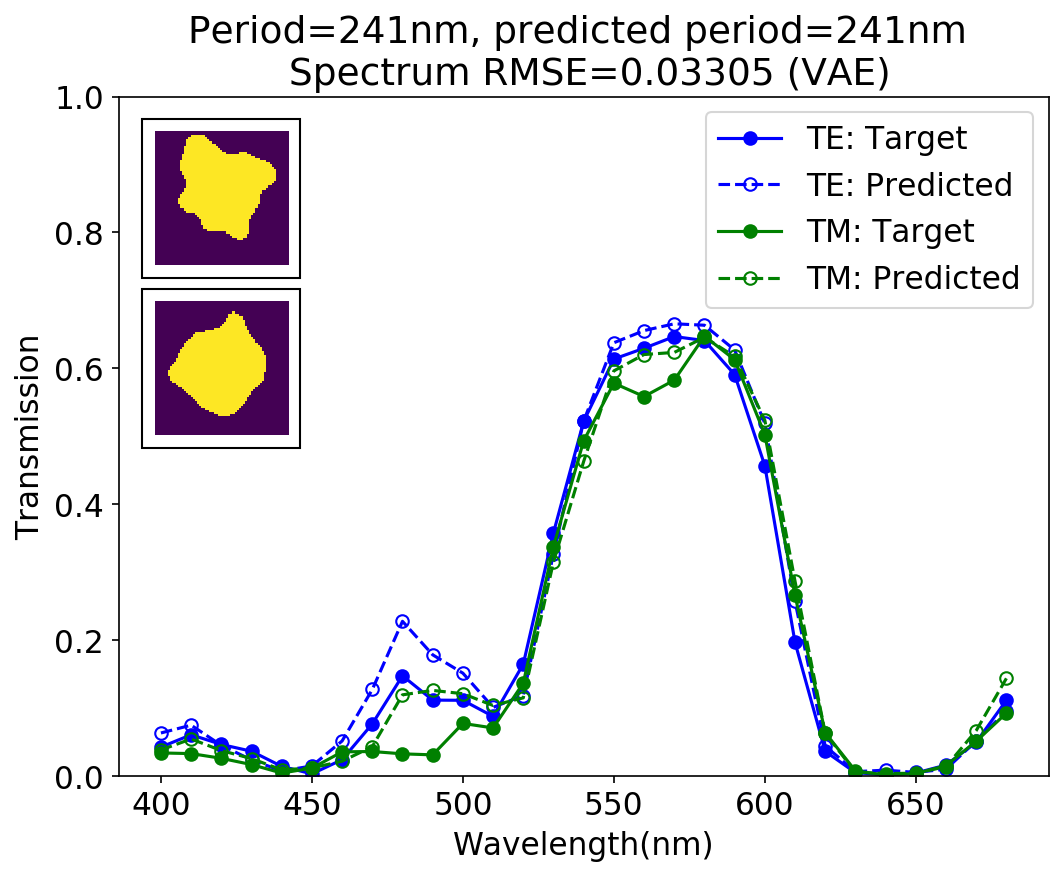

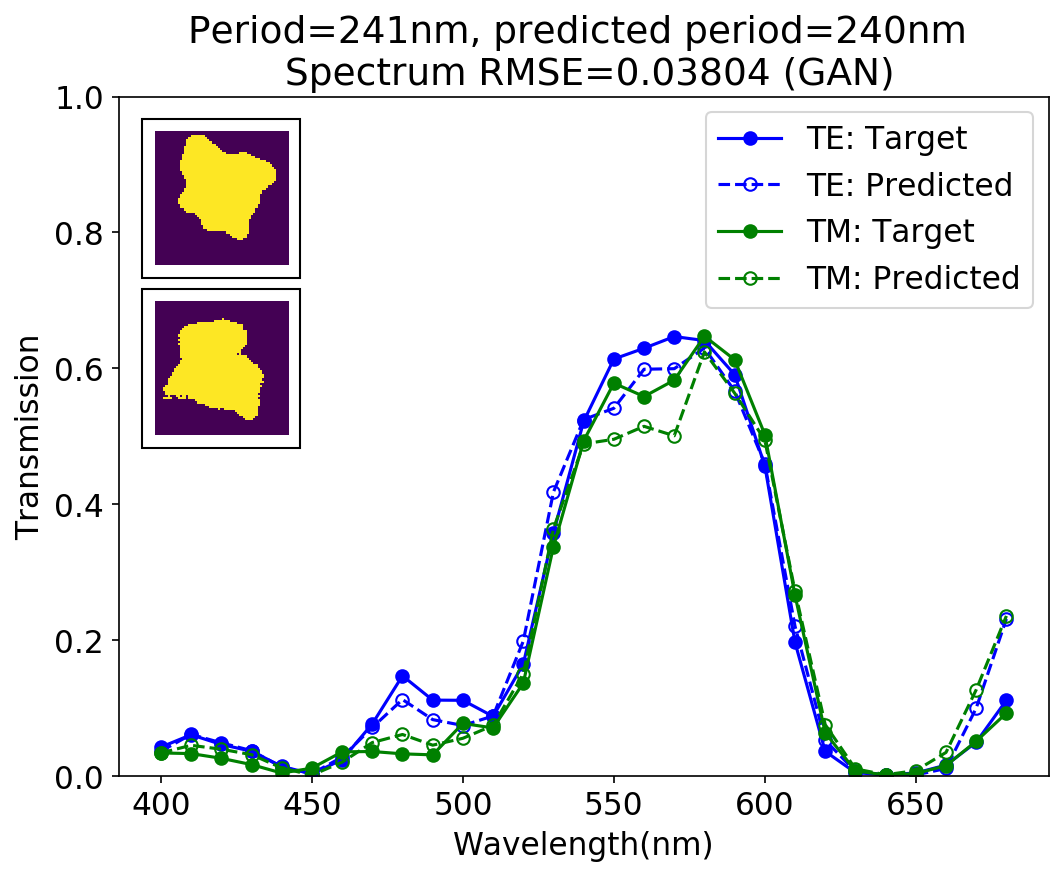

In [5]:
# and check several predicted structures
# 2379,, 1422, 2991, 2042, 3368, 4413, 1051, 3308, 846, 2707, 942

T = 499

gap_target, gap_pred, shape_raw, shape_pred, spec_target, spec_pred = gap_target_t, gap_pred_t, shape_raw_t, shape_pred_t, spec_target_t, spec_pred_t


wave = np.linspace(400, 680, 29)

imagebox = OffsetImage(shape_raw , zoom=1)
#imagebox = OffsetImage(shape_raw , zoom=1)
imagebox2 = OffsetImage(shape_pred[T,0,:,:] , zoom=1)

image_pred = sharp_image(shape_pred_t_raw[T,0,:,:], cut_off = 0.5, del_roudn=1)
imagebox2 = OffsetImage(image_pred , zoom=1)

fig, ax = plt.subplots(figsize=[8, 6], dpi=150)
plt.rcParams['font.size'] = '15'
plt.plot(wave, spec_target[T,:29], linestyle = 'solid', color='b', marker = 'o', label = 'TE: Target',)
plt.plot(wave, spec_pred[T,:29],  linestyle = 'dashed', color='b', marker = 'o', mfc='none',label = 'TE: Predicted')
plt.plot(wave, spec_target[T,29:], linestyle = 'solid', color='g', marker = 'o', label = 'TM: Target')
plt.plot(wave, spec_pred[T,29:],  linestyle = 'dashed', color='g', marker = 'o', mfc='none',label = 'TM: Predicted')

plt.xlabel('Wavelength(nm)')
plt.ylabel('Transmission')
plt.title('Target spectrum')# (center=500nm, width=30nm, peak=0.1)')
plt.ylim([0,1])
plt.legend()

mse = np.sqrt(np.mean((spec_target[T,:]-spec_pred[T,:])**2))
plt.title('Period={:d}nm, predicted period={:d}nm \n Spectrum RMSE={:.5f} (Tandem)'.format(int(gap_target),int(gap_pred[T]), mse))
plt.legend(loc = 'upper right')

ab = AnnotationBbox(imagebox, (420, 0.85))
ab2 = AnnotationBbox(imagebox2, (420, 0.6))
ax.add_artist(ab)
ax.add_artist(ab2)

gap_target, gap_pred, shape_raw, shape_pred, spec_target, spec_pred = gap_target_v, gap_pred_v, shape_raw_v, shape_pred_v, spec_target_v, spec_pred_v

imagebox = OffsetImage(shape_raw, zoom=1)
#imagebox = OffsetImage(shape_raw , zoom=1)
imagebox2 = OffsetImage(shape_pred[T,0,:,:] , zoom=1)

image_pred = sharp_image(shape_pred_v_raw[T,0,:,:], cut_off = 0.5, del_roudn=1)
imagebox2 = OffsetImage(image_pred , zoom=1)

fig, ax = plt.subplots(figsize=[8, 6], dpi=150)
plt.rcParams['font.size'] = '15'
plt.plot(wave, spec_target[T,:29], linestyle = 'solid', color='b', marker = 'o', label = 'TE: Target',)
plt.plot(wave, spec_pred[T,:29],  linestyle = 'dashed', color='b', marker = 'o', mfc='none',label = 'TE: Predicted')
plt.plot(wave, spec_target[T,29:], linestyle = 'solid', color='g', marker = 'o', label = 'TM: Target')
plt.plot(wave, spec_pred[T,29:],  linestyle = 'dashed', color='g', marker = 'o', mfc='none',label = 'TM: Predicted')

plt.xlabel('Wavelength(nm)')
plt.ylabel('Transmission')
plt.title('Target spectrum')# (center=500nm, width=30nm, peak=0.1)')
plt.ylim([0,1])
plt.legend()

mse = np.sqrt(np.mean((spec_target[T,:]-spec_pred[T,:])**2))
plt.title('Period={:d}nm, predicted period={:d}nm \n Spectrum RMSE={:.5f} (VAE)'.format(int(gap_target),int(gap_pred[T]), mse))
plt.legend(loc = 'upper right')

ab = AnnotationBbox(imagebox, (420, 0.85))
ab2 = AnnotationBbox(imagebox2, (420, 0.6))
ax.add_artist(ab)
ax.add_artist(ab2)


gap_target, gap_pred, shape_raw, shape_pred, spec_target, spec_pred = gap_target_g, gap_pred_g, shape_raw_g, shape_pred_g, spec_target_g, spec_pred_g


imagebox = OffsetImage(shape_raw, zoom=1)
#imagebox = OffsetImage(shape_raw , zoom=1)
imagebox2 = OffsetImage(shape_pred[T,0,:,:] , zoom=1)

image_pred = sharp_image(shape_pred_g_raw[T,0,:,:], cut_off = 0.5, del_roudn=1)
imagebox2 = OffsetImage(image_pred , zoom=1)

fig, ax = plt.subplots(figsize=[8, 6], dpi=150)
plt.rcParams['font.size'] = '15'
plt.plot(wave, spec_target[T,:29], linestyle = 'solid', color='b', marker = 'o', label = 'TE: Target',)
plt.plot(wave, spec_pred[T,:29],  linestyle = 'dashed', color='b', marker = 'o', mfc='none',label = 'TE: Predicted')
plt.plot(wave, spec_target[T,29:], linestyle = 'solid', color='g', marker = 'o', label = 'TM: Target')
plt.plot(wave, spec_pred[T,29:],  linestyle = 'dashed', color='g', marker = 'o', mfc='none',label = 'TM: Predicted')

plt.xlabel('Wavelength(nm)')
plt.ylabel('Transmission')
plt.title('Target spectrum')# (center=500nm, width=30nm, peak=0.1)')
plt.ylim([0,1])
plt.legend()

mse = np.sqrt(np.mean((spec_target[T,:]-spec_pred[T,:])**2))
plt.title('Period={:d}nm, predicted period={:d}nm \n Spectrum RMSE={:.5f} (GAN)'.format(int(gap_target),int(gap_pred[T]), mse))
plt.legend(loc = 'upper right')

ab = AnnotationBbox(imagebox, (420, 0.85))
ab2 = AnnotationBbox(imagebox2, (420, 0.6))
ax.add_artist(ab)
ax.add_artist(ab2)

(-0.0025, 0.15)

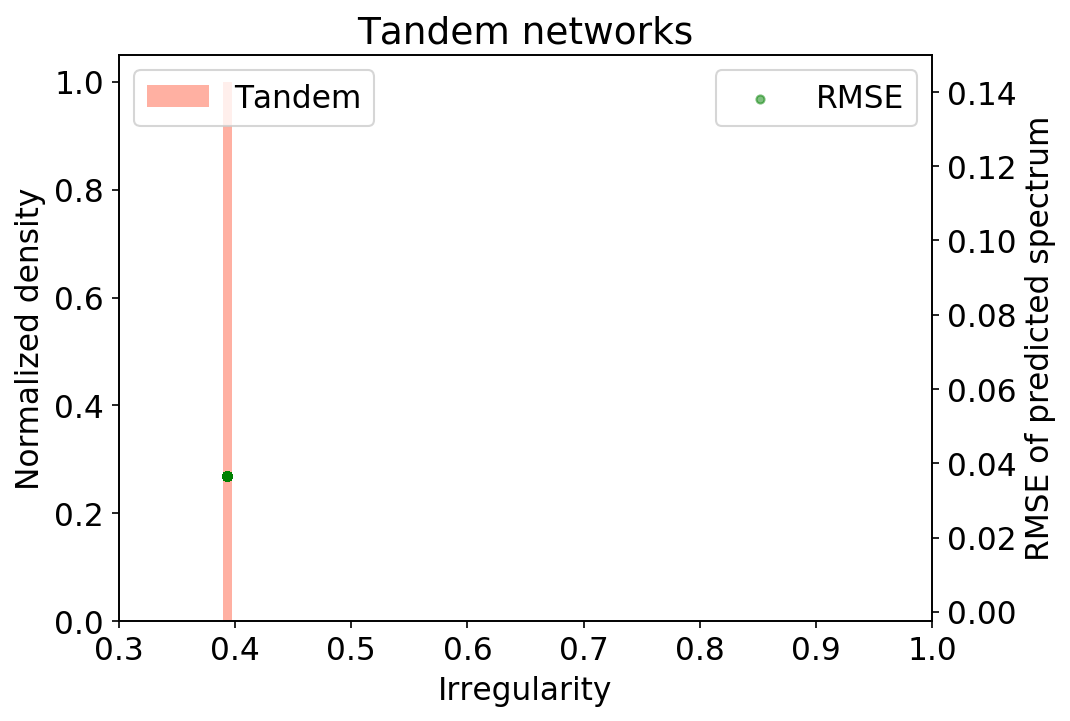

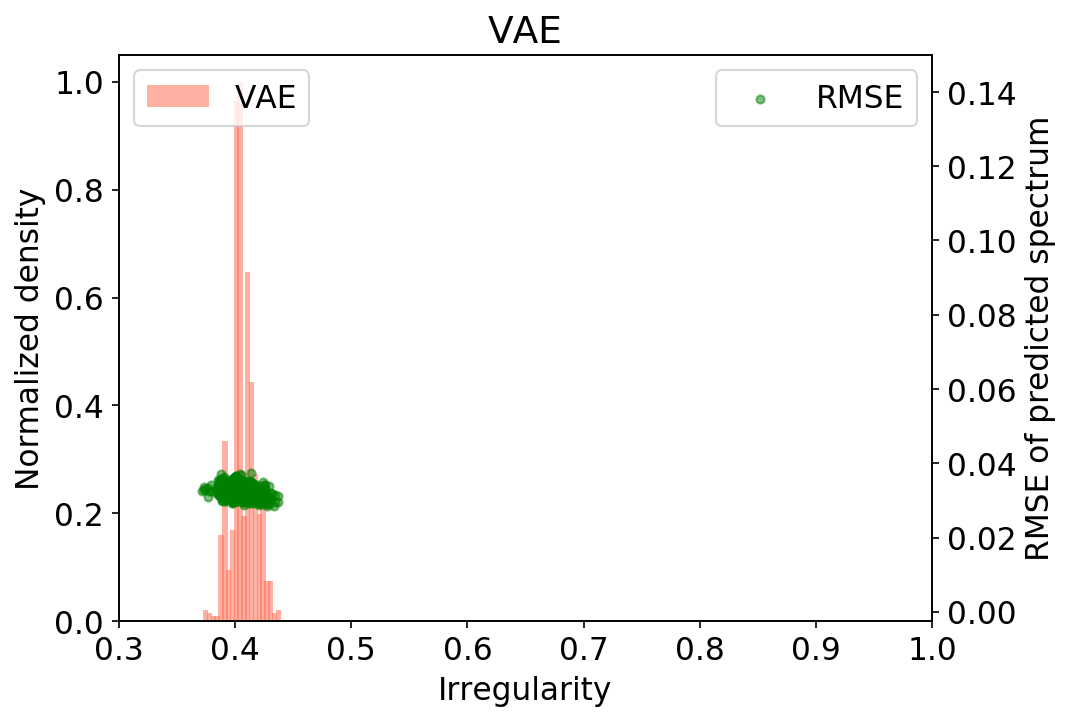

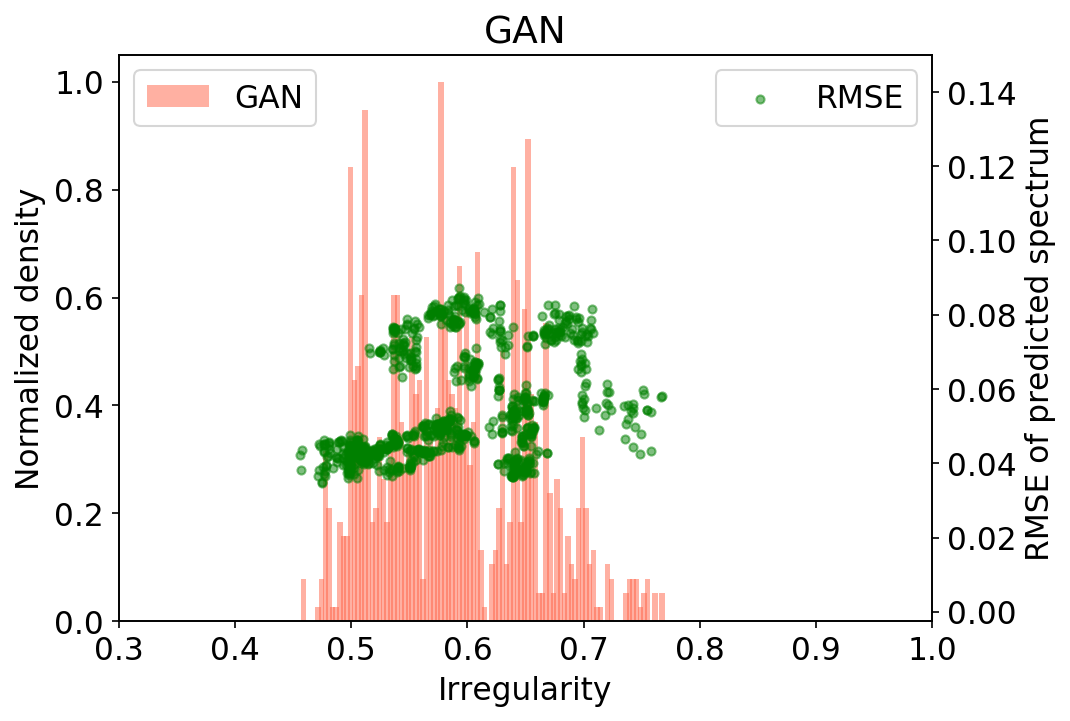

In [8]:
# Plot the result for show diversity for a give target


xlim = [0.3, 1.0]
ylim = [-0.0025, 0.15]



rmse_pred_spec = np.sqrt(np.mean(np.square(np.abs(spec_pred_t - spec_target_t)), axis=1))
irr_pred = irr_pred_t

h_t = np.histogram(irr_pred[0,:], bins=2000, density=True)
d_t, b_t = np.insert(h_t[0], 0, 0), h_t[1]
d_t = d_t/max(d_t)
d_t, b_t = np.insert(d_t, 21, 0), np.insert(b_t, 21, xlim[1])

plt.rcParams['font.size'] = '15'
fig, ax = plt.subplots(figsize=[7,5], dpi=150)
plt.bar(b_t, d_t, (xlim[1]-xlim[0])/100, fc='tomato', alpha=0.5, label='Tandem')
plt.legend(loc='upper left')
plt.xlabel('Irregularity')
plt.ylabel('Normalized density')
plt.title('Tandem networks')
plt.xlim(xlim)

ax2 = ax.twinx()
plt.scatter(irr_pred[0,:], rmse_pred_spec, color='g',label='RMSE',  alpha=0.5, s=15)
plt.ylabel('RMSE of predicted spectrum')
plt.xlabel('Irregularity')
plt.legend(loc='upper right')
plt.ylim(ylim)



rmse_pred_spec = np.sqrt(np.mean(np.square(np.abs(spec_pred_v - spec_target_v)), axis=1))
irr_pred = irr_pred_v

h_t = np.histogram(irr_pred[0,:], bins=20, density=True)
d_t, b_t = np.insert(h_t[0], 0, 0), h_t[1]
d_t = d_t/max(d_t)
d_t, b_t = np.insert(d_t, 21, 0), np.insert(b_t, 21, xlim[1])

plt.rcParams['font.size'] = '15'
fig, ax = plt.subplots(figsize=[7,5], dpi=150)
plt.bar(b_t, d_t, (xlim[1]-xlim[0])/150, fc='tomato', alpha=0.5, label='VAE')
plt.legend(loc='upper left')
plt.xlabel('Irregularity')
plt.ylabel('Normalized density')
plt.title('VAE')
plt.xlim(xlim)

ax2 = ax.twinx()
plt.scatter(irr_pred[0,:], rmse_pred_spec, color='g',label='RMSE', alpha=0.5, s=15)
plt.ylabel('RMSE of predicted spectrum')
plt.xlabel('Irregularity')
plt.legend(loc='upper right')
plt.ylim(ylim)




rmse_pred_spec = np.sqrt(np.mean(np.square(np.abs(spec_pred_g - spec_target_g)), axis=1))
irr_pred = irr_pred_g

h_t = np.histogram(irr_pred[0,:], bins=100, density=True)
d_t, b_t = np.insert(h_t[0], 0, 0), h_t[1]
d_t = d_t/max(d_t)
d_t, b_t = np.insert(d_t, 21, 0), np.insert(b_t, 21, xlim[1])

plt.rcParams['font.size'] = '15'
fig, ax = plt.subplots(figsize=[7,5], dpi=150)

plt.bar(b_t, d_t, (xlim[1]-xlim[0])/150, fc='tomato', alpha=0.5, label='GAN')
plt.legend(loc='upper left')
plt.xlabel('Irregularity')
plt.ylabel('Normalized density')
plt.title('GAN')
plt.xlim(xlim)

ax2 = ax.twinx()
plt.scatter(irr_pred[0,:], rmse_pred_spec, color='g',label='RMSE', alpha=0.5, s=15)
plt.ylabel('RMSE of predicted spectrum')
plt.xlabel('Irregularity')
plt.legend(loc='upper right')
plt.ylim(ylim)

